In [1]:
import warnings # ignore warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Import the data
critics = pd.read_csv('./data/rotten_tomatoes_critic_reviews_50k.csv')
critics

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...,...
49995,m/1110242-collateral_damage,Chris Hewitt,False,St. Paul Pioneer Press,Rotten,NaN,2002-02-07,The smarter an Arnold Schwarzenegger movie tri...
49996,m/1110242-collateral_damage,Nick Carter,False,Milwaukee Journal Sentinel,Rotten,NaN,2002-02-07,A relative letdown.
49997,m/1110242-collateral_damage,Gary Dowell,True,Dallas Morning News,Rotten,NaN,2002-02-07,The movie straddles the fence between escapism...
49998,m/1110242-collateral_damage,Walter Chaw,False,Film Freak Central,Rotten,0/4,2002-02-07,Enough similarities to Gymkata and Howie Long'...


In [3]:
# Import the data
movies = pd.read_csv('./data/rotten_tomatoes_movies.csv')
movies

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17707,m/zoot_suit,Zoot Suit,Mexican-American gangster Henry Reyna (Daniel ...,NaN,R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",1981-10-02,...,MCA Universal Home Video,Rotten,56.0,9.0,Upright,74.0,1195.0,2,5,4
17708,m/zootopia,Zootopia,From the largest elephant to the smallest shre...,The brilliantly well-rounded Zootopia offers a...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",2016-03-04,...,Walt Disney Animation Studios,Certified-Fresh,98.0,291.0,Upright,92.0,101511.0,50,285,7
17709,m/zorba_the_greek,Zorba the Greek,Traveling to inspect an abandoned mine his fat...,NaN,NR,"Action & Adventure, Art House & International,...",NaN,NaN,"Anthony Quinn, Alan Bates, Irene Papas, Lila K...",1964-12-17,...,Fox,Fresh,80.0,10.0,Upright,86.0,7146.0,0,8,2
17710,m/zulu,Zulu,"In 1879, the Zulu nation hands colonial Britis...",Zulu patiently establishes a cast of colorful ...,PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",1964-06-17,...,Paramount Pictures,Fresh,96.0,23.0,Upright,91.0,30193.0,6,22,1


In [63]:
df = critics.merge(movies, how='inner', on=['rotten_tomatoes_link'])
df = df[['rotten_tomatoes_link', 
         'movie_title', 
         'critics_consensus', 
         'review_content', 
         'tomatometer_status']]
df

,rotten_tomatoes_link,movie_title,critics_consensus,review_content,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,A fantasy adventure that fuses Greek mythology...,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,"Uma Thurman as Medusa, the gorgon with a coiff...",Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,With a top-notch cast and dazzling special eff...,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,Whether audiences will get behind The Lightnin...,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,What's really lacking in The Lightning Thief i...,Rotten
...,...,...,...,...,...
49995,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",The smarter an Arnold Schwarzenegger movie tri...,Rotten
49996,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",A relative letdown.,Rotten
49997,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",The movie straddles the fence between escapism...,Rotten
49998,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",Enough similarities to Gymkata and Howie Long'...,Rotten


In [64]:
df.isnull().sum()

rotten_tomatoes_link       0
movie_title                0
critics_consensus       9796
review_content          8805
tomatometer_status        43
dtype: int64

In [65]:
# Nulls can't be filled because there is no basleline review to fill them with
# Doesn't make sense to fill nulls with any content 
# because we are trying to use the text in review_content to predict tomatometer_status
df[df['review_content'].isnull()]

,rotten_tomatoes_link,movie_title,critics_consensus,review_content,tomatometer_status
80,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,NaN,Rotten
182,m/0878835,Please Give,Nicole Holofcener's newest might seem slight i...,NaN,Certified-Fresh
283,m/0878835,Please Give,Nicole Holofcener's newest might seem slight i...,NaN,Certified-Fresh
293,m/10,10,Blake Edwards' bawdy comedy may not score a pe...,NaN,Fresh
294,m/10,10,Blake Edwards' bawdy comedy may not score a pe...,NaN,Fresh
...,...,...,...,...,...
49936,m/1110048-pornographer,The Pornographer,NaN,NaN,Rotten
49937,m/1110048-pornographer,The Pornographer,NaN,NaN,Rotten
49981,m/1110236-wash,The Wash,"Sloppily-made, amateurish, and scarce on laugh...",NaN,Rotten
49986,m/1110236-wash,The Wash,"Sloppily-made, amateurish, and scarce on laugh...",NaN,Rotten


In [66]:
df[df['critics_consensus'].isnull()]

,rotten_tomatoes_link,movie_title,critics_consensus,review_content,tomatometer_status
596,m/1000123-310_to_yuma,3:10 to Yuma,NaN,"Despite an abundance of talk, this 1957 film i...",Fresh
597,m/1000123-310_to_yuma,3:10 to Yuma,NaN,NaN,Fresh
598,m/1000123-310_to_yuma,3:10 to Yuma,NaN,"Fine Daves, Ford collaborative western",Fresh
599,m/1000123-310_to_yuma,3:10 to Yuma,NaN,It's rather talky but always remains lively an...,Fresh
600,m/1000123-310_to_yuma,3:10 to Yuma,NaN,A taut Western (obviously inspired by High Noo...,Fresh
...,...,...,...,...,...
49933,m/1110048-pornographer,The Pornographer,NaN,NaN,Rotten
49934,m/1110048-pornographer,The Pornographer,NaN,NaN,Rotten
49935,m/1110048-pornographer,The Pornographer,NaN,Not a soft-core porn flick with a mildly profe...,Rotten
49936,m/1110048-pornographer,The Pornographer,NaN,NaN,Rotten


In [67]:
df = df.dropna(subset=['review_content', 'critics_consensus', 'tomatometer_status'])

In [68]:
df['review_content'].isnull().sum()

0

In [69]:
df.duplicated().sum()

16

In [70]:
df[df.duplicated()]

,rotten_tomatoes_link,movie_title,critics_consensus,review_content,tomatometer_status
7369,m/10009212-ben_x,Ben X,Thoughtful and provocative Dutch film concerne...,The best movie I've seen about teen angst sinc...,Fresh
7757,m/10009254-shutter,Shutter,Being a remake of a Thai horror film instead o...,"Workmanlike at best; derivative, predictable a...",Rotten
11168,m/10010552-gigantic,Gigantic,"This overly quirky, incessantly whimsical indi...",Gigantic is the sort of kitchen sink movie man...,Rotten
13594,m/10011582-TRON_legacy,Tron Legacy,"Tron Legacy boasts dazzling visuals, but its h...","The film is visually dazzling, but the main pr...",Rotten
14358,m/10012014-babies,Babies,Babies is a joyous celebration of humankind th...,Because of the inherent adorability of the fou...,Fresh
21509,m/1010678-invasion_of_the_body_snatchers,Invasion of the Body Snatchers,One of the best political allegories of the 19...,The original version of the oft-filmed science...,Certified-Fresh
35577,m/1069707-othello,Othello,"Perhaps less than the sum of its parts, Othell...",Fine Shakespeare adaptation,Fresh
42381,m/1093611-anna_and_the_king,Anna and the King,Beautiful cinematography can't prevent Anna an...,This version of Anna and the King plays it ent...,Rotten
42572,m/1093641-hurricane,The Hurricane,Thanks in large part to one of Denzel Washingt...,Denzel Washington gives yet another kick-ass p...,Certified-Fresh
42654,m/1093655-diamonds,Diamonds,Kirk Douglas' flinty performance fails to over...,A thoroughly enjoyable piece.,Rotten


In [71]:
df = df.drop_duplicates()

In [72]:
df.duplicated().sum()

0

In [73]:
df

,rotten_tomatoes_link,movie_title,critics_consensus,review_content,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,A fantasy adventure that fuses Greek mythology...,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,"Uma Thurman as Medusa, the gorgon with a coiff...",Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,With a top-notch cast and dazzling special eff...,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,Whether audiences will get behind The Lightnin...,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,What's really lacking in The Lightning Thief i...,Rotten
...,...,...,...,...,...
49995,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",The smarter an Arnold Schwarzenegger movie tri...,Rotten
49996,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",A relative letdown.,Rotten
49997,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",The movie straddles the fence between escapism...,Rotten
49998,m/1110242-collateral_damage,Collateral Damage,"Despite its timely subject matter, Collateral ...",Enough similarities to Gymkata and Howie Long'...,Rotten


In [74]:
X = df.drop(columns=["tomatometer_status", "movie_title", "rotten_tomatoes_link"])
y = df["tomatometer_status"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [75]:
df['tomatometer_status'].value_counts()

Rotten             15101
Certified-Fresh    11838
Fresh               7557
Name: tomatometer_status, dtype: int64

In [76]:
# Check out the y_train class balance 
y_train.value_counts()

Rotten             12081
Certified-Fresh     9480
Fresh               6035
Name: tomatometer_status, dtype: int64

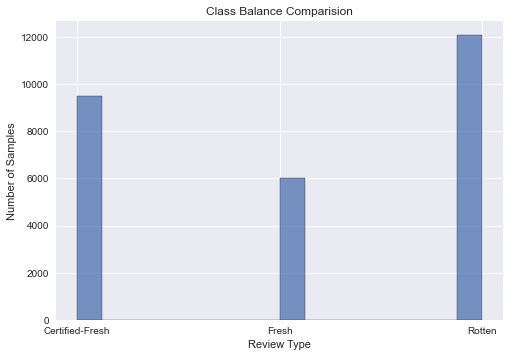

In [77]:
# Plot the class the balance on a histogram
sns.histplot(data=y_train.sort_values(), 
             discrete=False)

plt.title("Class Balance Comparision")
plt.xlabel("Review Type")
plt.ylabel("Number of Samples");

In [78]:
# Check out the y_test class balance 
y_test.value_counts()

Rotten             3020
Certified-Fresh    2358
Fresh              1522
Name: tomatometer_status, dtype: int64

In [81]:
np.unique(y_test,
          return_counts=True)

(array([0, 1, 2]), array([2358, 1522, 3020], dtype=int64))

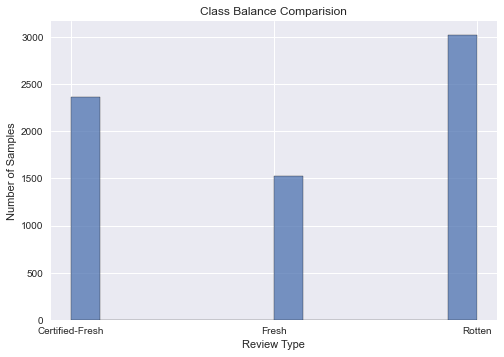

In [79]:
# Plot the class the balance on a histogram

sns.histplot(data=y_test.sort_values(), 
             discrete=False)

plt.title("Class Balance Comparision")
plt.xlabel("Review Type")
plt.ylabel("Number of Samples");

In [80]:
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(y_train), print(y_test)

[0 2 1 ... 0 0 0]
[2 1 0 ... 2 2 1]


(None, None)

In [82]:
from PIL import Image
from wordcloud import WordCloud #library that allows word cloud to be generated

def generate_word_cloud(dataframe_df,column_name,img_file=None,background_color="black",max_words=2000):
    """ This function generates word cloud
    
    Args:
        dataframe: the datafram object which contains column whose word cloud is to be generated
        column_name: the name of the column in dataframw whose cloud is to be generated
        
    Returns:
        None
    """
    #convert the column specified by column_name in dataset_df(dataframe) to list
    sentences_list = dataframe_df[column_name].tolist()
    
    #convert a list to sentence
    #sentences_single_string = " ".join(sentences_list)
    sentences_single_string = " ".join(map(str,sentences_list))
    
    #plot word cloud
    plt.figure(figsize=(15,15))
    
    img_mask = None
    
    if img_file != None:
        img_mask = np.array(Image.open(img_file))

    wc = WordCloud(mask=img_mask,
                   max_words=max_words,
                   background_color=background_color)        
        
    plt.imshow(wc.generate(sentences_single_string),interpolation="bilinear")
    plt.title("Word Cloud For " +  column_name)
    plt.show()

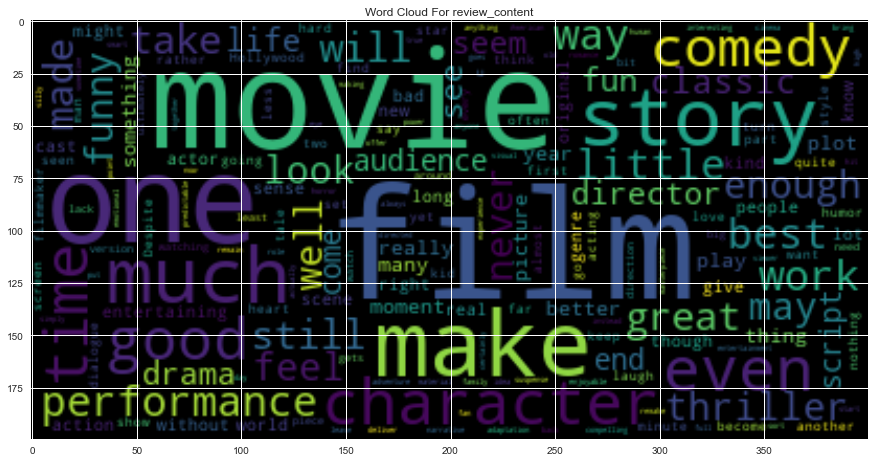

Total Time Taken: 9933.10546875 ms


In [83]:
import time
tic= time.time()
generate_word_cloud(df,
                    "review_content",
                    background_color="black")
toc = time.time()
diff = 1000*(toc - tic)
print("Total Time Taken: " + str(diff) + " ms")

In [84]:
# Create an intance of the RegexpTokenizer with the variable name `tokenizer`
# The regex pattern should select all words with three or more characters
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')

# Create an instance of nltk's PorterStemmer with the variable name `stemmer`
lemmatizer = WordNetLemmatizer()

In [85]:
def preprocess_text(text, tokenizer, stopwords_list, lemmatizer):
    # Standardize case (lowercase the text)
    lowered = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lowered)
    
    # Remove stopwords using `stopwords_list`
    stopped_tokens = [word for word in tokens if word not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    lemmas = [lemmatizer.lemmatize(token) for token in stopped_tokens]

    # Return the preprocessed text
    return lemmas

In [94]:
# View a record without process_string() applied
X_train["critics_consensus"].iloc[44]

'With a clever script and hilarious interplay among the cast, The Hangover nails just the right tone of raunchy humor, and the non-stop laughs overshadow any flaw.'

In [95]:
preprocess_text(X_train["critics_consensus"].iloc[44], tokenizer, stopwords_list, lemmatizer)

['clever',
 'script',
 'hilarious',
 'interplay',
 'among',
 'cast',
 'hangover',
 'nail',
 'right',
 'tone',
 'raunchy',
 'humor',
 'non',
 'stop',
 'laugh',
 'overshadow',
 'flaw']

In [98]:
df['review_content'] = df['review_content'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))

In [99]:
df['critics_consensus'] = df['critics_consensus'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))

In [100]:
X_train['review_content'] = X_train['review_content'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))


In [101]:
X_train['critics_consensus'] = X_train['critics_consensus'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))

In [102]:
X_test['review_content'] = X_test['review_content'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))

In [103]:
X_test['critics_consensus'] = X_test['critics_consensus'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))

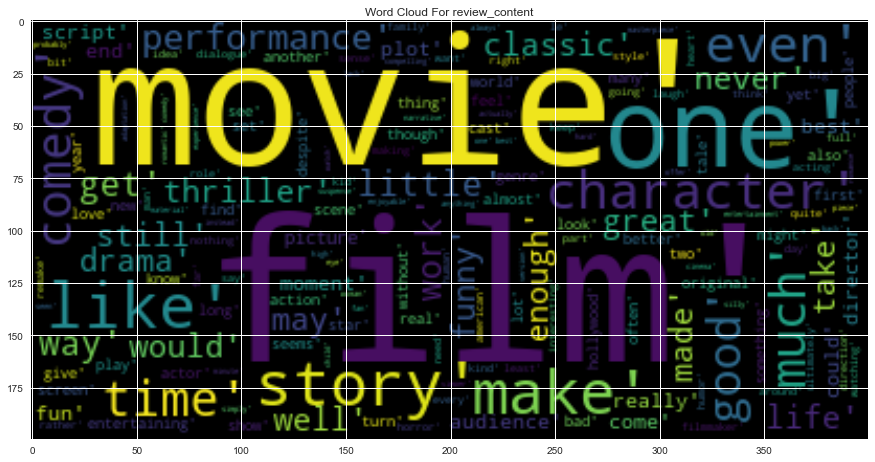

Total Time Taken: 12.865451574325562 ms


In [105]:
tic = time.time()
generate_word_cloud(df,
                    "review_content",
                    background_color="black")
toc = time.time()
diff = toc - tic
print("Total Time Taken: " + str(diff) + " ms")

In [106]:
# Save file to csv
df.to_csv("./data/df.csv")
X_train.to_csv("./data/X_train.csv")
X_test.to_csv("./data/X_test.csv")

In [107]:
df = pd.read_csv("./data/df.csv")
X_train = pd.read_csv("./data/X_train.csv")
X_test = pd.read_csv("./data/X_test.csv")

In [119]:
vectorizer = CountVectorizer()

labels = label_encoder.fit_transform(df["tomatometer_status"])
feature_1 = vectorizer.fit_transform(df["review_content"].tolist())
feature_2 = vectorizer.fit_transform(df["critics_consensus"].tolist())
# feture_1 = pd.DataFrame(feature_1)
# feature_2 = pd.DataFrame(feature_2)
features = feature_1.merge(feature_2)
matrix = pd.DataFrame.sparse.from_spmatrix(data=features, columns=vectorizer.get_feature_names())

AttributeError: merge not found

In [ ]:
def plot_top_words(document_term_df,upper_threshold=10000,lower_threshold=10,count=20):
    
    #for time purposes
    tic = time.time()
    
    top_word_freq = {}
    #build frequency dictionary
    for col in document_term_df.columns:
        
        col_count = document_term_df[col].to_numpy().max()
        
        if lower_threshold < col_count < upper_threshold:
            top_word_freq[col] = col_count
            
        if len(top_word_freq) > count:
            break

    #print thresholds
    print("Upper Limit: " + str(upper_threshold))
    print("Lower Limit: " + str(lower_threshold))
    print("Requested Count: " + str(count))
    
    plt.figure(figsize=(20,10))
    
    y_vals = [top_word_freq[word] for word in top_word_freq.keys()]
    
    anotates = list(top_word_freq.keys())
    
    x_vals = [i for i in range(0,len(y_vals))]
    
    plt.scatter(x_vals,y_vals)

    plt.title("Top Word Counts")
    plt.xlabel("Top Words")
    plt.ylabel("Word Frequency")
    
    for y,a,x in zip(y_vals,anotates,x_vals):
        plt.annotate(a, #anotate
                     (x,y), #for this data point 
                    textcoords="offset points", #how to position text
                    xytext=(0,10), #distance from text to points (x,y)
                    ha="center") #horizontal alignment can beleft, right or center 
    
    #for time purposes
    toc = time.time()
    tictoc = (toc-tic)*1000
    print("Time Taken: " + str(tictoc) + " ms")

Upper Limit: 10
Lower Limit: 3
Requested Count: 25
Time Taken: 1376.2147426605225 ms


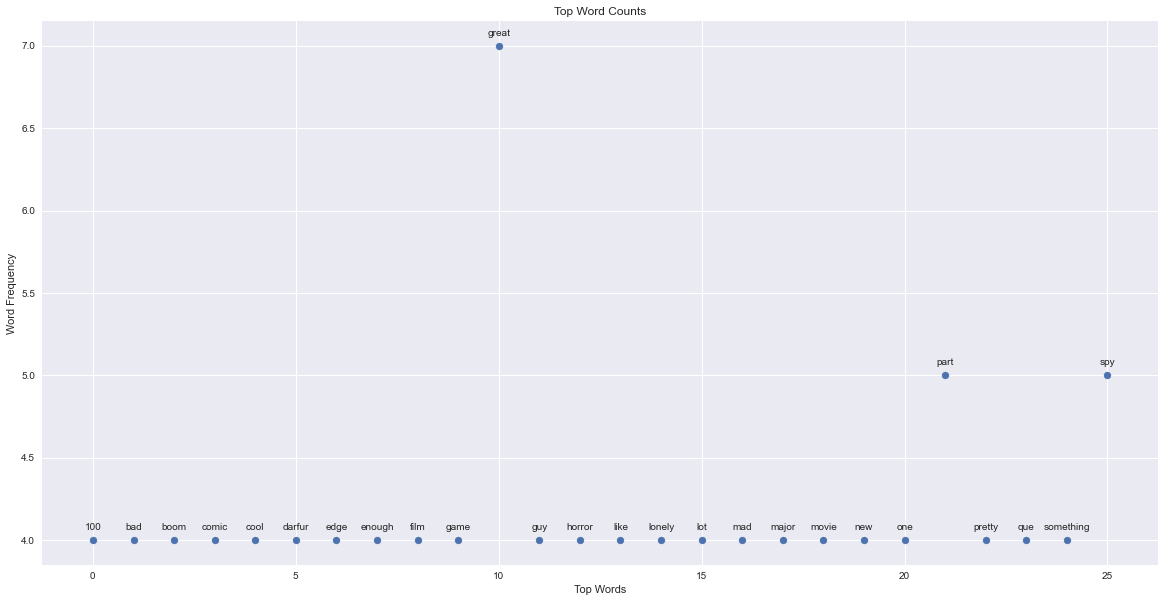

In [37]:
plot_top_words(matrix,
               upper_threshold=10,
               lower_threshold=3,
               count=25)

Upper Limit: 10
Lower Limit: 2
Requested Count: 25
Time Taken: 322.12257385253906 ms


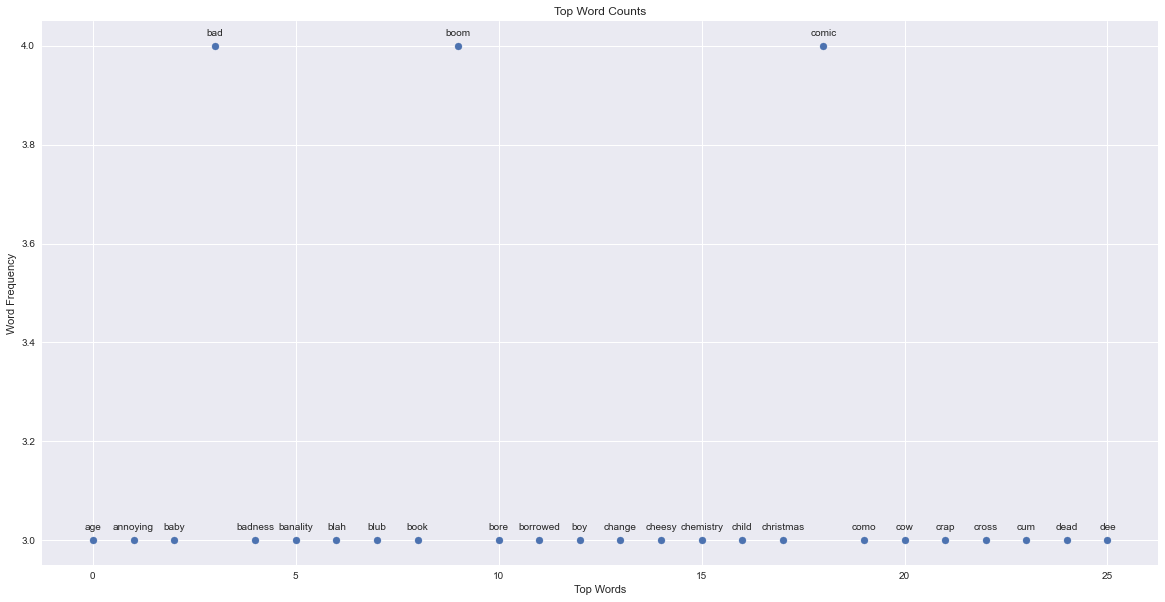

In [39]:
plot_top_words(matrix[labels == 1],
               upper_threshold=10,
               lower_threshold=2,
               count=25)

Upper Limit: 10
Lower Limit: 2
Requested Count: 25
Time Taken: 497.9891777038574 ms


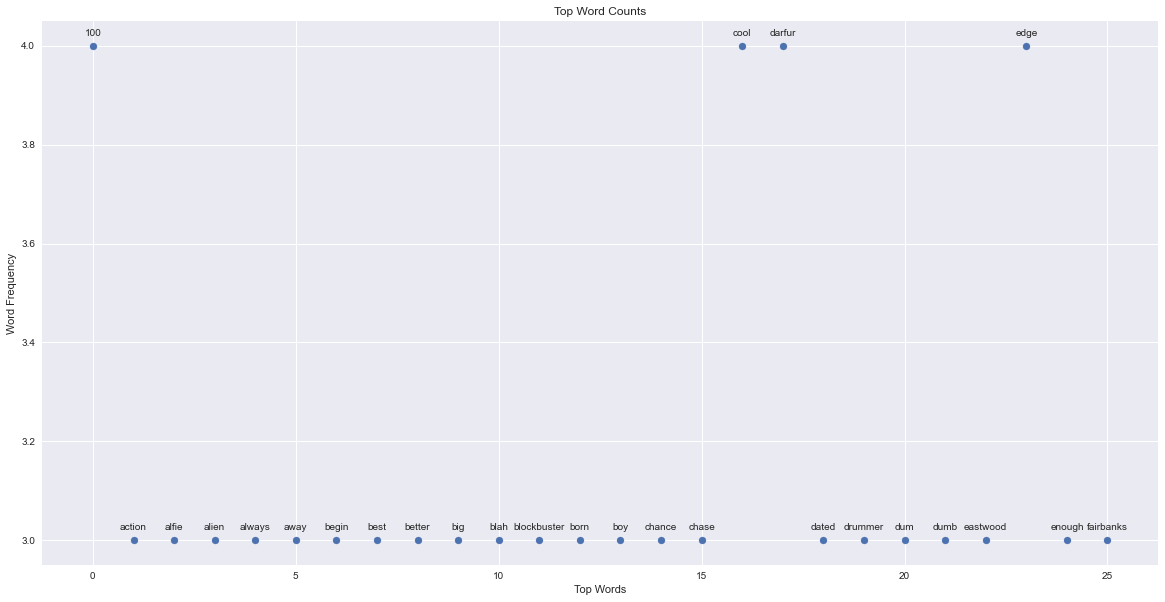

In [40]:
plot_top_words(matrix[labels == 0],
               upper_threshold=10,
               lower_threshold=2,
               count=25)

In [62]:
tf_idf = TfidfVectorizer()


X_train = tf_idf.fit_transform(X_train.tolist())
X_test = tf_idf.transform(X_test.tolist())

print(X_train.shape, X_test.shape)

AttributeError: 'DataFrame' object has no attribute 'tolist'

              precision    recall  f1-score   support

       Fresh       0.60      1.00      0.75      4977
      Rotten       0.00      0.00      0.00      3259

    accuracy                           0.60      8236
   macro avg       0.30      0.50      0.38      8236
weighted avg       0.37      0.60      0.46      8236



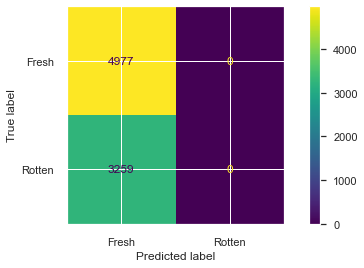

In [45]:
# Create Dummy/Baseliner
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)


# Set figsize and font scale
sns.set(rc={'figure.figsize':(9, 4)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Fresh', 'Rotten']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['Fresh', 'Rotten']
print(classification_report(y_test, y_pred, target_names=target_names))

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   47.4s finished


Mean Training Score: 82.11%

Mean Test Score: 78.25%

Optimal Parameters: {'estimator__C': 1.0, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 77.84%

              precision    recall  f1-score   support

       Fresh       0.79      0.88      0.83      4977
      Rotten       0.78      0.63      0.70      3259

    accuracy                           0.78      8236
   macro avg       0.78      0.76      0.76      8236
weighted avg       0.78      0.78      0.78      8236



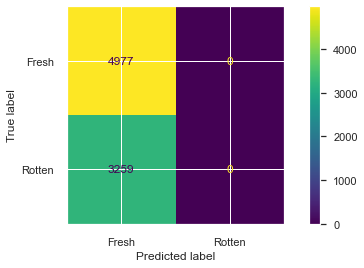

In [46]:
pipe = Pipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
])



param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']



grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)



# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)



print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Label 0, 1, 2 in classification reports
target_names = ['Fresh', 'Rotten']
print(classification_report(y_test, y_pred, target_names=target_names))



# Set figsize and font scale
sns.set(rc={'figure.figsize':(9, 4)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Fresh', 'Rotten']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg');